In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import normaltest

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_palette('muted')

## Load & Visualize Time Series

In [2]:
#eth_price_raw = pd.read_csv('ethereum_price.csv')
#df = eth_price_raw[['Date', 'Close']].copy()
#df.columns = ['date', 'eth']
#df['date'] = pd.to_datetime(df['date'], format='%b %d, %Y')
#df.sort_values('date', inplace=True)
#df.reset_index(drop=True, inplace=True)
#df.head()

In [3]:
eth_raw = pd.read_pickle('eth_df.pkl')
print(eth_raw.info())
eth_raw.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 7 columns):
date          1131 non-null datetime64[ns]
open          1131 non-null float64
high          1131 non-null float64
low           1131 non-null float64
close         1131 non-null float64
volumefrom    1131 non-null float64
volumeto      1131 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 61.9 KB
None


,date,open,high,low,close,volumefrom,volumeto
0,2015-08-06,0.6747,3.0,0.6747,3.0,123.93,371.79
1,2015-08-07,3.0000,3.0,0.1500,1.2,2119.43,1438.16


In [4]:
eth_raw.tail(2)

,date,open,high,low,close,volumefrom,volumeto
1129,2018-09-08,196.77,208.38,185.01,195.99,803730.43,1.580799e+08
1130,2018-09-09,195.99,202.59,186.92,196.98,649556.50,1.268624e+08


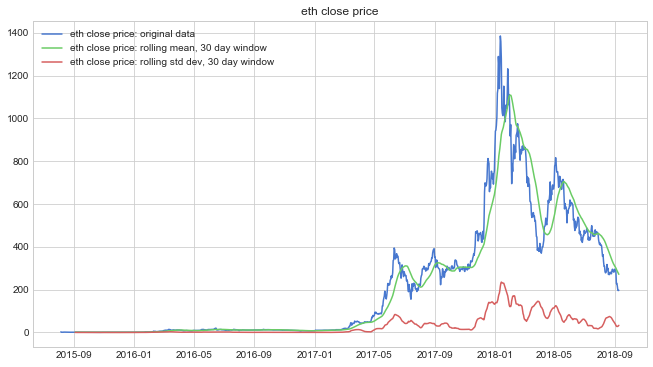

adf: -1.807060571948588
pval: 0.37696199282738063
critical vals {'1%': -3.436270983129607, '5%': -2.8641544150183553, '10%': -2.5681619941180744}


In [5]:
df = eth_raw.copy()
df.rename(columns={'close':'eth'}, inplace=True)
plt.figure(figsize=(11,6))
plt.plot(
    df['date'],
    df['eth'],
    label='eth close price: original data'
)
plt.plot(
    df['date'],
    df['eth'].rolling(30).mean(),
    label='eth close price: rolling mean, 30 day window'
)
plt.plot(
    df['date'],
    df['eth'].rolling(30).std(),
    label='eth close price: rolling std dev, 30 day window'
)
plt.title('eth close price')
plt.legend(loc='upper left')
plt.show()

from statsmodels.tsa.stattools import adfuller
print('adf: {0}\npval: {1}\ncritical vals {2}'.format(
    adfuller(df['eth'])[0],
    adfuller(df['eth'])[1],
    adfuller(df['eth'])[4]))

## Changepoint Detection

In [6]:
ts = df[['date', 'eth']]
ts = ts.set_index('date')

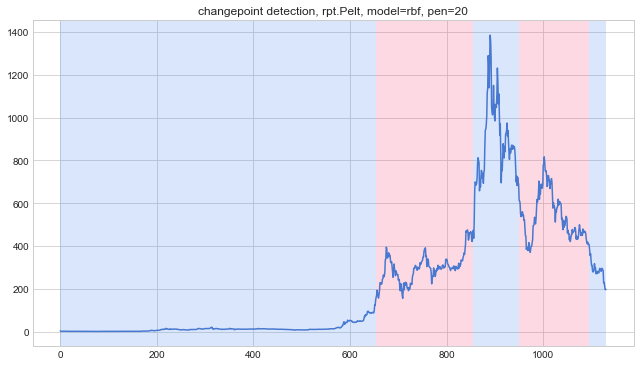

[655, 855, 950, 1095, 1131]


In [7]:
import ruptures as rpt
cpts = rpt.Pelt(model='rbf').fit_predict(ts, pen=20)

rpt.display(ts, cpts, figsize=(9,5))
plt.title('changepoint detection, rpt.Pelt, model=rbf, pen=20')
plt.show()
print(cpts)

In [8]:
# split df by changepoints
df_01 = df[:655]
df_02 = df[655:855]
df_03 = df[855:950]
df_04 = df[950:1095]
df_05 = df[1095:]

#print(len(df_01) + len(df_02) + len(df_03) + len(df_04))
#print(len(df))

In [9]:
# a few attempts at stationarity
df_05['diff_1'] = df_05.eth - df_05.eth.shift(1)
df_05['diff_2'] = df_05.eth - df_05.eth.shift(2)
df_05['log'] = np.log(df_05.eth)
df_05['log_diff_1'] = np.log(df_05.eth).diff().dropna()
df_05['sqrt'] = np.sqrt(df_05.eth)

# drop nans from differencing
df_05 = df_05[2:]
#df_04.head()

print('\ndiff_1\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05['diff_1'])[0],
    adfuller(df_05['diff_1'])[1],
    adfuller(df_05['diff_1'])[4]))

print('\ndiff_2\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05['diff_2'])[0],
    adfuller(df_05['diff_2'])[1],
    adfuller(df_05['diff_2'])[4]))

print('\nlog\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05['log'])[0],
    adfuller(df_05['log'])[1],
    adfuller(df_05['log'])[4]))

print('\nlog_diff_1\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05['log_diff_1'])[0],
    adfuller(df_05['log_diff_1'])[1],
    adfuller(df_05['log_diff_1'])[4]))

print('\nsqrt\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05['sqrt'])[0],
    adfuller(df_05['sqrt'])[1],
    adfuller(df_05['sqrt'])[4]))


diff_1
adf=-6.5085786025456995, npval=1.1150764113091709e-08
critical vals={'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}

diff_2
adf=-3.349462014687139, npval=0.012807192888507752
critical vals={'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}

log
adf=-0.6010174187237314, npval=0.8707519661589569
critical vals={'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}

log_diff_1
adf=-6.30552672373701, npval=3.330885906418666e-08
critical vals={'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}

sqrt
adf=-0.8443103817570272, npval=0.8057585973877541
critical vals={'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}


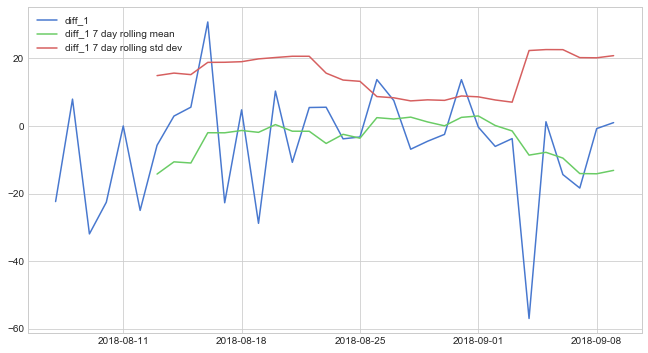


diff_1
adf=-6.5085786025456995, npval=1.1150764113091709e-08
critical vals={'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}


In [10]:
window = 7

plt.figure(figsize=(11,6))
plt.plot(df_05.date,
         df_05.diff_1,
         label='diff_1')
plt.plot(df_05.date,
         df_05.diff_1.rolling(window).mean(),
         label='diff_1 {} day rolling mean'.format(window))
plt.plot(df_05.date,
         df_05.diff_1.rolling(window).std(),
         label='diff_1 {} day rolling std dev'.format(window))
plt.legend()
plt.show()

print('\ndiff_1\nadf={0}, npval={1}\ncritical vals={2}'.format(
    adfuller(df_05['diff_1'])[0],
    adfuller(df_05['diff_1'])[1],
    adfuller(df_05['diff_1'])[4]))

## Autocorrelation Functions (ACF/PACF)

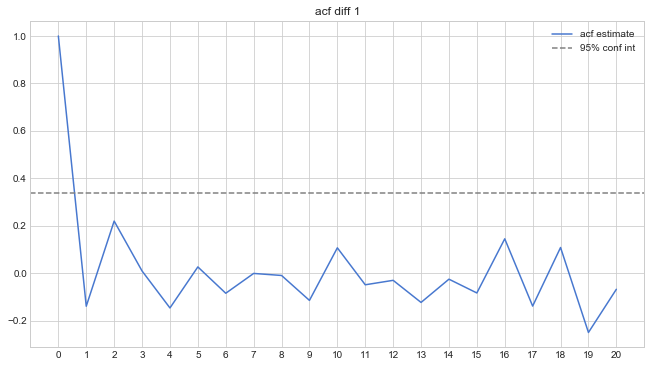

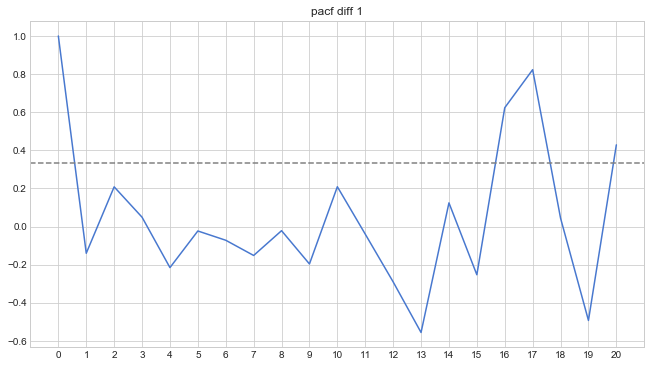

In [11]:
diff_1_acf = acf(df_05.diff_1, nlags=20)
diff_1_pacf = pacf(df_05.diff_1, nlags=20, method='ols')

plt.figure(figsize=(11,6))
plt.plot(diff_1_acf, label='acf estimate')
plt.axhline(y=1.96/np.sqrt(len(df_05.diff_1)),
            linestyle='--',
            c='gray',
            label='95% conf int')
plt.xticks(np.arange(0,21))
plt.title('acf diff 1')
plt.legend()
plt.show()

plt.figure(figsize=(11,6))
plt.plot(diff_1_pacf, label='pacf estimate')
plt.axhline(y=1.96/np.sqrt(len(df_05.diff_1)),
            linestyle='--',
            c='gray',
            label='95% conf int')
plt.xticks(np.arange(0,21))
plt.title('pacf diff 1')
plt.show()

## ARIMA Modeling

In [12]:
def rmse(model):
    rmse = np.sqrt((model.resid ** 2).mean())
    return rmse

In [13]:
base = ARIMA(df_05.eth, order=(0,1,0)).fit()
print(base.summary())
print('base rmse: {}'.format(rmse(base)))

                             ARIMA Model Results                              
Dep. Variable:                  D.eth   No. Observations:                   33
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -138.420
Method:                           css   S.D. of innovations             16.048
Date:                Mon, 10 Sep 2018   AIC                            280.840
Time:                        19:57:56   BIC                            283.833
Sample:                             1   HQIC                           281.847
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.8058      2.794     -1.720      0.095     -10.281       0.670
base rmse: 16.0482737729871


In [14]:
ar1 = ARIMA(df_05.eth, order=(1,1,0)).fit()
print(ar1.summary())
print('ar1 rmse: {}'.format(rmse(ar1)))

                             ARIMA Model Results                              
Dep. Variable:                  D.eth   No. Observations:                   33
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -138.190
Method:                       css-mle   S.D. of innovations             15.934
Date:                Mon, 10 Sep 2018   AIC                            282.381
Time:                        19:57:56   BIC                            286.870
Sample:                             1   HQIC                           283.891
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -4.8650      2.492     -1.952      0.060      -9.749       0.019
ar.L1.D.eth    -0.1171      0.172     -0.680      0.502      -0.455       0.220
                                    Roots       

In [15]:
ma1 = ARIMA(df_05.eth, order=(0,1,1)).fit()
print(ma1.summary())
print('ma1 rmse: {}'.format(rmse(ma1)))

                             ARIMA Model Results                              
Dep. Variable:                  D.eth   No. Observations:                   33
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -138.248
Method:                       css-mle   S.D. of innovations             15.963
Date:                Mon, 10 Sep 2018   AIC                            282.496
Time:                        19:57:56   BIC                            286.985
Sample:                             1   HQIC                           284.006
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -4.8494      2.542     -1.908      0.066      -9.832       0.133
ma.L1.D.eth    -0.0881      0.150     -0.589      0.560      -0.381       0.205
                                    Roots       

**Results:** appears there is no autoregressive or moving average component to this data. Compared to a base linear model, AR(1) and MA(1) models return slightly higher (worse) AIC scores and non significant coefficients.

## Exogenous Variables
- Etherem related
    - high
    - low
    - open
    - volume
    - market cap (need to get this working)
- Other Indices (exclude for now need to get current data)
    - VIX
    - DXY
    - EFFR
- Other Cryptocurrencies
    - BTC: Bitcoin
    - XRP: Ripple
    - EOS: EOS.IO
    - LTC: Litecoin
    - XLM: Stellar (need to figure out why its not pulling first values but where I'm working is correct)
    - XMR: Monero

In [16]:
dfx = pd.read_pickle('crypto_df.pkl')
dfx.rename(columns={'open':'eth_open',
                    'high':'eth_high',
                    'low':'eth_low',
                    'close':'eth_close',
                    'volumefrom':'eth_volume_from',
                    'volumeto':'eth_volume_to'},
           inplace=True)
print(dfx.shape)
dfx.tail(3)

(1131, 16)


,date,eth_open,eth_high,eth_low,eth_close,eth_volume_from,eth_volume_to,vix,dxy,effr,btc,xrp,eos,ltc,xlm,xmr
1128,2018-09-07,215.14,220.02,190.08,196.77,866674.05,1.771377e+08,14.88,89.72,1.91,6200.16,0.2769,4.74,53.14,0.1943,103.81
1129,2018-09-08,196.77,208.38,185.01,195.99,803730.43,1.580799e+08,14.88,89.72,1.91,6249.07,0.2759,4.94,54.72,0.1912,105.07
1130,2018-09-09,195.99,202.59,186.92,196.98,649556.50,1.268624e+08,14.88,89.72,1.91,6319.76,0.2662,5.03,53.86,0.1896,105.56


In [17]:
# split on changepoints returned earlier
# split df by changepoints
dfx_01 = dfx[:655]
dfx_02 = dfx[655:855]
dfx_03 = dfx[855:950]
dfx_04 = dfx[950:1095]
dfx_05 = dfx[1095:]

In [18]:
# inspect but data should be pretty clean by this point
print(dfx.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1131 entries, 0 to 1130
Data columns (total 16 columns):
date               1131 non-null datetime64[ns]
eth_open           1131 non-null float64
eth_high           1131 non-null float64
eth_low            1131 non-null float64
eth_close          1131 non-null float64
eth_volume_from    1131 non-null float64
eth_volume_to      1131 non-null float64
vix                1131 non-null float64
dxy                1130 non-null float64
effr               1131 non-null object
btc                1131 non-null float64
xrp                1131 non-null float64
eos                439 non-null float64
ltc                1131 non-null float64
xlm                602 non-null float64
xmr                1131 non-null float64
dtypes: datetime64[ns](1), float64(14), object(1)
memory usage: 150.2+ KB
None


In [19]:
# check for missingness applies more for broader date ranges
# than working with here, eos came out in jan 2018
print(dfx_05.isnull().sum())

date               0
eth_open           0
eth_high           0
eth_low            0
eth_close          0
eth_volume_from    0
eth_volume_to      0
vix                0
dxy                0
effr               0
btc                0
xrp                0
eos                0
ltc                0
xlm                0
xmr                0
dtype: int64


In [20]:
X = dfx_05.loc[:, ~(dfx_05.columns).isin(['vix', 'dxy', 'effr', 'eth_close', 'date'])]
y = dfx_05.eth_close

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

base2 = SARIMAX(endog=y, order=(0,1,0)).fit()
base2_pred = base2.predict()

basex = SARIMAX(endog=y,
                exog=X.astype(float),
                order=(0,1,0)).fit()
basex_pred = basex.predict()

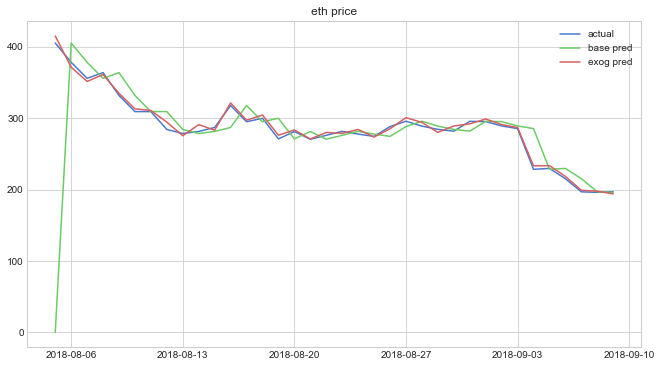

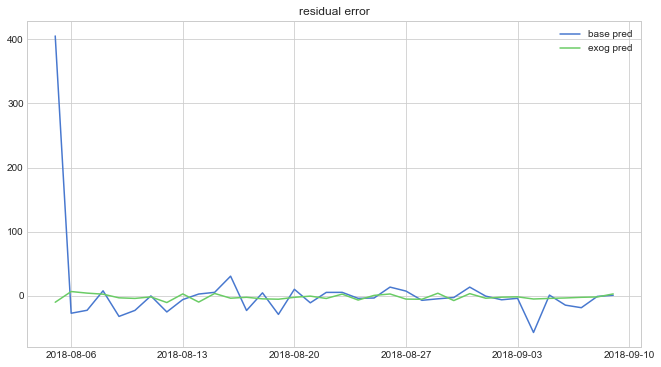

rmse base: 69.61713921314363
rmse exog: 4.661964776956943


In [22]:
plt.figure(figsize=(11,6))
plt.plot(dfx_05.date, dfx_05.eth_close, label='actual')
plt.plot(dfx_05.date, base2_pred, label='base pred')
plt.plot(dfx_05.date, basex_pred, label='exog pred')
plt.legend()
plt.title('eth price')
plt.show()

plt.figure(figsize=(11,6))
plt.plot(dfx_05.date, base2.resid, label='base pred')
plt.plot(dfx_05.date, basex.resid, label='exog pred')
plt.legend()
plt.title('residual error')
plt.show()

print('rmse base: {}'.format(rmse(base2)))
print('rmse exog: {}'.format(rmse(basex)))